This notebook features an overview of the competition, EDA (Exploratory Data Analysis) and Ensembling of different models to get you started with the competition.

![](https://blog.groomit.me/wp-content/uploads/2018/02/petfinder2.jpg)

## PetFinder.my Adoption Prediction

## Table of contents

- [Data Columns](#1)
- [Dependencies](#2)
- [Preparation](#3)
- [Data Description](#4)
- [Visualization](#5)
- [Metric](#6)
- [Data Cleaning](#10)
- [Tree Ensembling](#7)
- [Predictions](#8)
- [Kaggle Submission](#9)

## Data columns <a id="1"></a>

[Source](https://www.kaggle.com/c/petfinder-adoption-prediction/data)

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


## Dependencies <a id="2"></a>

In [1]:
# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Seed for reproducability
seed = 12345
np.random.seed(seed)

# Info about dataset
# print('Files and directories: \n{}\n'.format(os.listdir("../input")))
# print('Within the train directory: \n{}\n'.format(os.listdir("../input/train")))
# print('Within the test directory: \n{}\n'.format(os.listdir("../input/test")))

## Preparation <a id="3"></a>

In [4]:
# Read in data
KAGGLE_DIR = '../input/'

train_df = pd.read_csv(KAGGLE_DIR + "train/train.csv")
test_df = pd.read_csv(KAGGLE_DIR + "test/test.csv")

## Data Description <a id="4"></a>

In [5]:
# Stats
print('Data Statistics:')
train_df.describe()

Data Statistics:


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [6]:
# Types
print('Types: ')
train_df.dtypes

Types: 


Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

In [7]:
# Overview
print('This dataset has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print('Example rows:')
train_df.head(3)

This dataset has 14993 rows and 24 columns
Example rows:


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3


## Visualization <a id="5"></a>

Text(0.5, 1.0, 'Type Distribution')

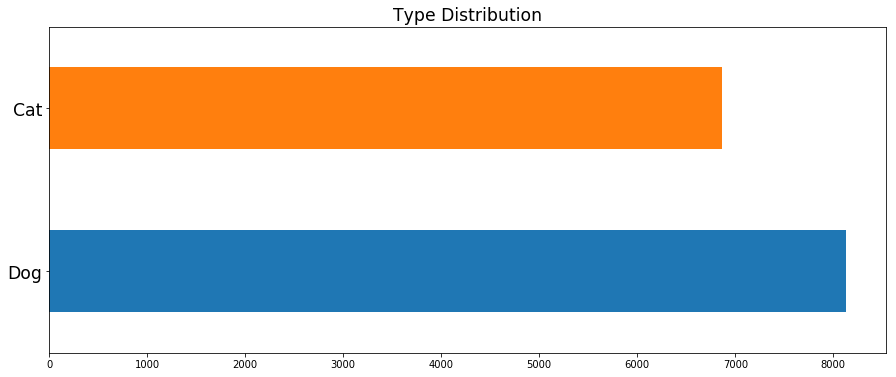

In [8]:
# Type distribution
train_df['Type'].value_counts().rename({1:'Dog',
                                        2:'Cat'}).plot(kind='barh',
                                                       figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.title('Type Distribution', fontsize='xx-large')

Text(0.5, 1.0, 'Gender distribution')

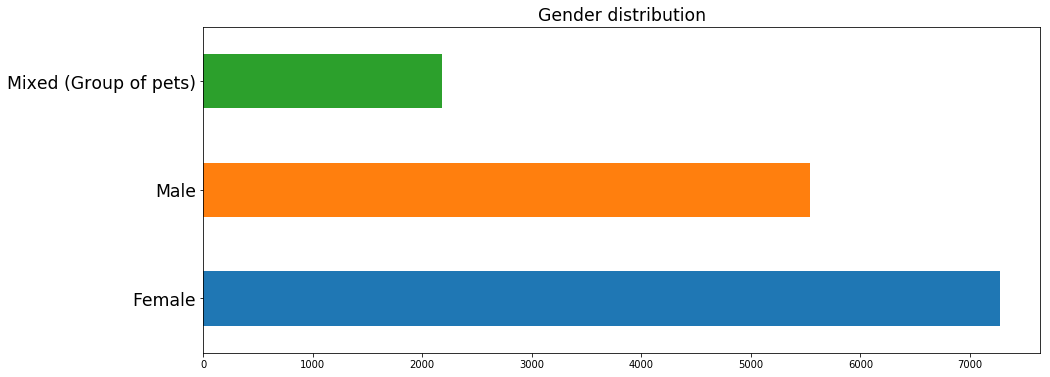

In [9]:
# Gender distribution
train_df['Gender'].value_counts().rename({1:'Male',
                                          2:'Female',
                                          3:'Mixed (Group of pets)'}).plot(kind='barh', 
                                                                           figsize=(15,6))
plt.yticks(fontsize='xx-large')
plt.title('Gender distribution', fontsize='xx-large')

Text(0.5, 0, 'Age in months')

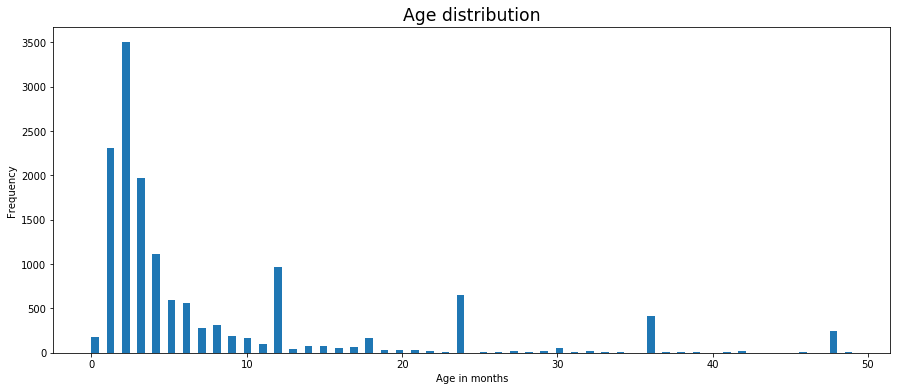

In [10]:
# Age distribution 
train_df['Age'][train_df['Age'] < 50].plot(kind='hist', 
                                           bins = 100, 
                                           figsize=(15,6), 
                                           title='Age distribution')
plt.title('Age distribution', fontsize='xx-large')
plt.xlabel('Age in months')

Text(0.5, 0, 'Photos')

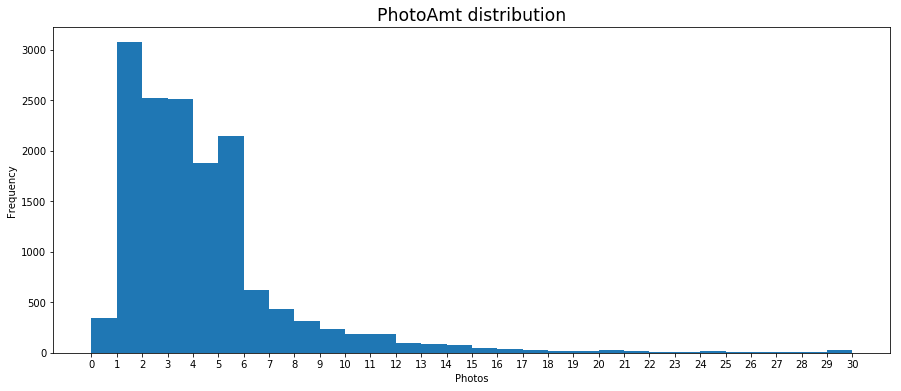

In [11]:
# Photo amount distribution
train_df['PhotoAmt'].plot(kind='hist', 
                          bins=30, 
                          xticks=list(range(31)), 
                          figsize=(15,6))
plt.title('PhotoAmt distribution', fontsize='xx-large')
plt.xlabel('Photos')

The values are determined in the following way:
0 - Pet was adopted on the same day as it was listed.
1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
4 - No adoption after 100 days of being listed.
(There are no pets in this dataset that waited between 90 and 100 days).


Text(0.5, 1.0, 'Adoption Speed (Target Variable)')

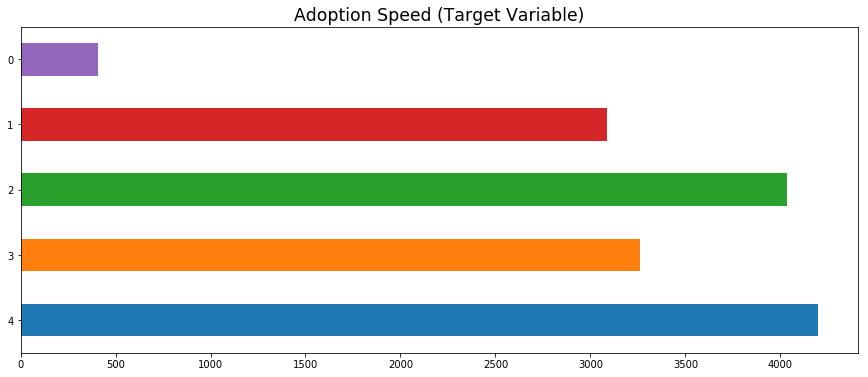

In [12]:
# Target variable (Adoption Speed)
print('The values are determined in the following way:\n\
0 - Pet was adopted on the same day as it was listed.\n\
1 - Pet was adopted between 1 and 7 days (1st week) after being listed.\n\
2 - Pet was adopted between 8 and 30 days (1st month) after being listed.\n\
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.\n\
4 - No adoption after 100 days of being listed.\n\
(There are no pets in this dataset that waited between 90 and 100 days).')

# Plot
train_df['AdoptionSpeed'].value_counts().sort_index(ascending=False).plot(kind='barh', 
                                                                          figsize=(15,6))
plt.title('Adoption Speed (Target Variable)', fontsize='xx-large')

In [13]:
# Example Description (of Nibble) ^^ 
print('Example Description (of Nibble) ^^ : ')
train_df['Description'][0]

Example Description (of Nibble) ^^ : 


"Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care."

## Metric <a id="6"></a>

The metric used for this competition is called ''Quadratic Weighted Kappa''.

We can use [scikit-learn's 'cohen_kappa_score' function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) almost straight out-of-the-box for measuring our predictions.

In [14]:
# Metric used for this competition (Quadratic Weigthed Kappa aka Quadratic Cohen Kappa Score)
def metric(y1,y2):
    return cohen_kappa_score(y1,y2, weights='quadratic')

## Data Cleaning <a id="10"></a>

In [15]:
# Clean up DataFrames
# Will try to implement these into the model later
target = train_df['AdoptionSpeed']
clean_df = train_df.drop(columns=['Name', 'RescuerID', 'Description', 'PetID', 'AdoptionSpeed'])
clean_test = test_df.drop(columns=['Name', 'RescuerID', 'Description', 'PetID'])

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(clean_df, target, test_size=0.15, random_state=1)

## Tree Ensembling <a id="7"></a>

We will use predictions from both a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), an [Extra Trees Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), an [AdaBoost Classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and a [Gaussian Naive Bayes Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Later we will take the average of all models to get the final predictions. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is used to get near-optimal parameters for almost all models.

In [17]:
# Create base models
clf = RandomForestClassifier()
clf2 = ExtraTreesClassifier()
clf3 = AdaBoostClassifier()
clf4 = GaussianNB()

# Create parameters to use for Grid Search
rand_forest_grid = {
    'bootstrap': [True],
    'max_depth': [77, 80, 83, 85],
    'max_features': ['auto'],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [5, 10],
    'n_estimators': [175, 200, 225]
}

extra_trees_grid = {
    'bootstrap' : [False, True], 
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : [77, 80, 83, 85], 
    'max_features': ['auto'], 
    'min_samples_leaf': [5, 10], 
    'min_samples_split': [5, 10],
    'n_estimators': [175, 200, 225]
}

adaboost_grid = {
    'n_estimators' : [200, 225, 250],
    'learning_rate' : [.1, .2 , .3, .4, .5],
    'algorithm' : ['SAMME.R']
}

# Search parameter space
rand_forest_gridsearch = GridSearchCV(estimator = clf, 
                           param_grid = rand_forest_grid, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 1)

extra_trees_gridsearch = GridSearchCV(estimator = clf2, 
                           param_grid = extra_trees_grid, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 1)

adaboost_gridsearch = GridSearchCV(estimator = clf3, 
                           param_grid = adaboost_grid, 
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 1)

In [18]:
# Fit the models
rand_forest_gridsearch.fit(x_train, y_train)
extra_trees_gridsearch.fit(x_train, y_train)
adaboost_gridsearch.fit(x_train, y_train)
clf4.fit(x_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   41.8s finished


Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  2.3min finished


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.4s finished


GaussianNB(priors=None, var_smoothing=1e-09)

In [19]:
# What are the best parameters for each model
print('Random Forest model:\n{}\n'.format(rand_forest_gridsearch.best_params_))
print('Extra Trees model:\n{}\n'.format(extra_trees_gridsearch.best_params_))
print('Adaboost model:\n{}\n'.format(adaboost_gridsearch.best_params_))

Random Forest model:
{'bootstrap': True, 'max_depth': 85, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}

Extra Trees model:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 175}

Adaboost model:
{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 250}



## XGBoost <a id="10"></a>

In [20]:
import xgboost as xgb

# Examine the default parameters
model = xgb.XGBClassifier()
param_grid = {"max_depth": [1,2,3],
              "max_features" : [1.0,1.5],
              "min_samples_leaf" : [3,5,9],
              "n_estimators": [300, 500],
              "learning_rate": [0.05,0.1,0.02]}
# Perform Grid Search CV
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 )
gs_cv.fit(clean_df, target)
print('XGboost model:\n{}\n'.format(gs_cv.best_params_))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

XGboost model:
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 500}



In [21]:
# Measure of performance 
# Useful for checking overfitting, performance, etc.
print('Random Forest score: ', metric(rand_forest_gridsearch.predict(x_test), 
                                y_test))
print('Extra Trees score: ', metric(extra_trees_gridsearch.predict(x_test), 
                                y_test))
print('Adaboost score: ', metric(adaboost_gridsearch.predict(x_test), 
                                y_test))
print('GaussianNB score: ', metric(clf4.predict(x_test), 
                                y_test))
print('XGboost score: ', metric(gs_cv.predict(x_test), 
                                y_test))

Random Forest score:  0.3609377354376133
Extra Trees score:  0.3246159380003414
Adaboost score:  0.32550362062562255
GaussianNB score:  0.2165610898528355
XGboost score:  0.3808118743017572


## Predictions <a id="8"></a>

In [22]:
# Get predictions
predictions1 = rand_forest_gridsearch.predict(clean_test)
predictions2 = extra_trees_gridsearch.predict(clean_test)
predictions3 = adaboost_gridsearch.predict(clean_test)
predictions4 = clf4.predict(clean_test)

# Combine predictions
final_predictions = []
# Get average of predictions
for pred in zip(predictions1, predictions2, predictions3, predictions4):
    final_predictions.append(int(round((sum(pred)) / 4, 0)))

In [23]:
# Compare predictions
prediction_df = pd.DataFrame({'PetID' : test_df['PetID'],
                              'Random Forest' : predictions1,
                              'Extra Trees' : predictions2,
                              'Adaboost' : predictions3,
                              'GaussianNB' : predictions4,
})

print('Predictions for each model: ')
prediction_df.head()

Predictions for each model: 


,PetID,Random Forest,Extra Trees,Adaboost,GaussianNB
0,378fcc4fc,2,2,2,2
1,73c10e136,4,4,4,4
2,72000c4c5,4,4,4,2
3,e147a4b9f,4,4,4,4
4,43fbba852,4,4,4,3


## Kaggle Submission <a id="9"></a>

In [ ]:
# Store predictions for Kaggle Submission
submission_df = pd.DataFrame(data={'PetID' : test_df['PetID'], 
                                   'AdoptionSpeed' : final_predictions})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# Check submission
submission_df.head()

In [ ]:
# Compare distributions of training set and test set (Adoption Speed)

# Plot 1
plt.figure(figsize=(15,4))
plt.subplot(211)
train_df['AdoptionSpeed'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.title('Target Variable distribution in training set', fontsize='large')

# Plot 2
plt.subplot(212)
submission_df['AdoptionSpeed'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.title('Target Variable distribution in predictions')

plt.subplots_adjust(top=2)